# Locally Weighted Regression

This is a **NON PARAMETRIC** (no parameters are part of the input that defines the model, JUST DATA). Instead of adjusting the model to all the Training values, it adjusts it to a single query value we wish to evaluate.

* THERE IS **NO TRAINING** all parameters $\theta$ are calculated on real time when we want to predict a $x_{query}$.

In [6]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist

##PATH TO THE DATA
# path = './data/'
path = '/content/drive/MyDrive/GitHub_Repo/Linear_Regression/LWR_data/' #EDIT FOLDER PATH AS NEEDED

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def plot_data(x,y,title):
    plt.figure(figsize=(10,4))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.plot(x[:,1],y,'bo')
    plt.title(title);

def plot_predictions(x,y,ypred,title):
    plt.figure(figsize=(10,4))
    plt.plot(x[:,1],y,'bo',label='ground truth')
    plt.plot(x[:,1],ypred,'rx',label='prediction')
    plt.suptitle(title,fontsize=12)
    plt.legend(loc='upper left')

* This is a **NON PARAMETRIC** (no parameters are part of the input that defines the model, JUST DATA).

* Instead of adjusting the model to all the Training values, it adjusts it to a single query value to calculate parameters in real life.

* It checks the distance between $x_{query}$ and all the X_samples. The closer a X_sample is to the $x_{query}$ the more weight it receives.

* The weight is calciulayed using a Kernel, tipically GaussianL

$$\omega_i = \text{exp}(-\frac{(x_i - x_{query})^2}{2\tau^2}) $$

  * Where $\tau$ is the bandwidth chosen empirically or cross validation
    * LARGER: The model becomes more GLOBAL, looking similar to a standard Linear Regression.

    * SMALLER: The model only focuses on those samples closer to the $x_{query}$
* The thetas are calculated on real time using:

  $$\theta = (X^TWX)^{-1}X^TWy $$
  * where W is a unit matrix with all the weights/distances between each X sample and $x_{query}$

* The predictions are calculated by:
  $$\hat{y}_query = x_{query}^T \theta$$

# Load Data
LWR its used when we want to model non linear data without asuming a fixed functional form. This is commonly used when :

* data changes beahviour in specific zones.
* when data has local patterns.
* when we dont want a global model.

This data looks like a wave but there are places where the data concentrates more.

In [7]:
# read an x,y csv file and add a column of ones to X.
def load_dataset(filename,add_intercept=True):
    data = np.loadtxt(path + filename, delimiter = ",", skiprows = 1)
    x,y = data[:,0], data[:,1]
    if add_intercept:
        x = np.stack((np.ones(x.shape[0],),x),axis=1)
    return x,y


xtrain,ytrain = load_dataset("lwr_train.csv")
xvalid,yvalid = load_dataset("lwr_valid.csv")
xtest,ytest = load_dataset("lwr_test.csv")

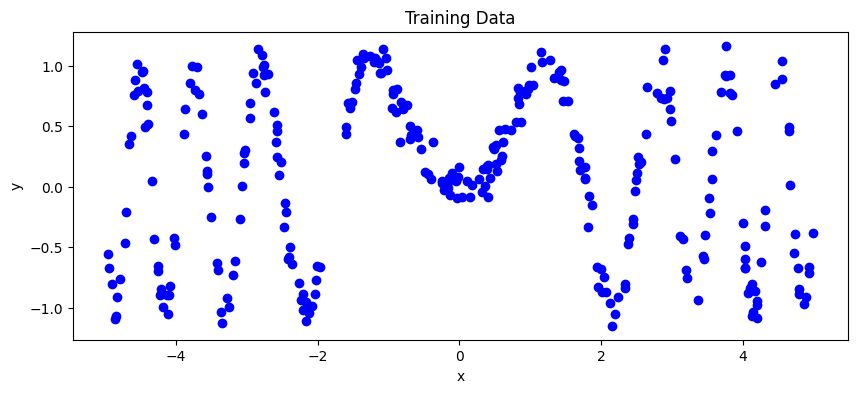

In [8]:
plot_data(xtrain,ytrain,'Training Data')

# Locally Weighted Regression

In [9]:
class LocallyWeightedLinearRegression():
    """Locally Weighted Regression (LWR).
    Example usage:
        > clf = LocallyWeightedLinearRegression(tau)
        > clf.fit(xtrain, ytrain)
        > clf.predict(xvalid)
    """

    def __init__(self, tau):
        super(LocallyWeightedLinearRegression, self).__init__()
        self.tau = tau
        self.x = None
        self.y = None

    def fit(self, x, y):
        """Fit LWR by saving the training set.

        :param x: Training example inputs. Shape (m, d).
        :param y: Training example labels. Shape (m,).
        """
        self.x = x
        self.y = y


    def predict(self, xq):
        """Make predictions given inputs xq.

        :param xq: Inputs of shape (n, d).
        :return ypred:  Outputs of shape (n,).
        """

        n, d = xq.shape

        # Get the distance diagonal matrix
        distances = cdist(xq, self.x, metric='euclidean')

        # Compute weights matrix W for all queries: shape (n,m) (1 line in vectorized form)
        w = np.exp(-(distances**2) / (2 * self.tau**2))

        # Initialize predictions in ypred to zeros (1 line in vectorized form)
        ypred = np.zeros(n)

        # While the code above is vectorized, we loop over query points
        # computing the diagnoal Wi matrix for that point from W, and using the
        # weighted normal equation for solving for the theta vector.
        # Then predict on query with the dot product of that theta and the query vector
        # (can't fully avoid the loop due to per-query W)
        # (about seven lines here)
        for query_point in range(n):
          w_i = w[query_point]
          Wi = np.diag(w_i)
          theta = np.linalg.inv(self.x.T @ Wi @ self.x) @ (self.x.T @ Wi @ self.y)
          ypred[query_point] = xq[query_point] @ theta
        return ypred

In [10]:
tau = 0.1

clf = LocallyWeightedLinearRegression(tau)
clf.fit(xtrain, ytrain)
ypred = clf.predict(xvalid)

## Testing

Mean Squared Error =  0.02422458937980463


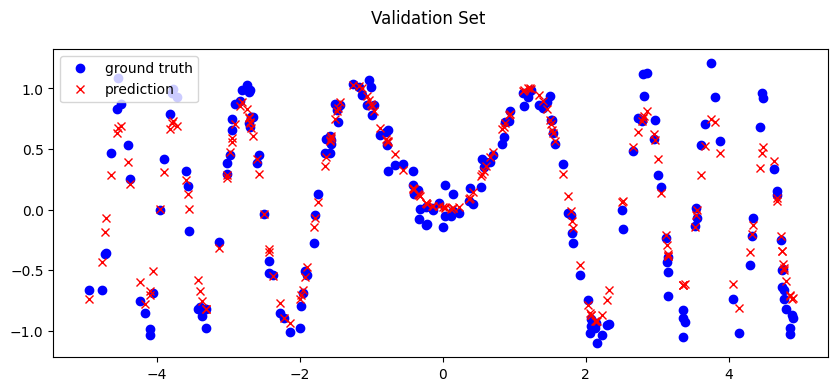

In [11]:
tau = 0.1

clf = LocallyWeightedLinearRegression(tau)
clf.fit(xtrain, ytrain)
ypred = clf.predict(xvalid)
plot_predictions(xvalid,yvalid,ypred,'Validation Set')
print('Mean Squared Error = ', np.mean((ypred - yvalid)**2))

The data seems to underfit since it is not fitting some specific points near inflexion points. If it were to overfit we could expect to see the curves to have more predictions

* HIGH COMPUTATIONAL COST WHEN EVALUATING MULTIPLE QUERIES AND WHEN DATA X SAMPLES ARE A LOT

# Cross Validation do determine best $\tau$

* loop over the given set of taus, training the model on (xtrain,ytrain), and measuring mean squared error on (xvalid,yvalid).

* select the tau with the lowest validation set error, call it best_tau. The lowest error is lowest_mse

In [13]:
taus = [3e-2, 5e-2, 1e-1, 5e-1, 1e0, 1e1]

lowest_mse = np.inf
for tau in taus:
  clf = LocallyWeightedLinearRegression(tau)
  clf.fit(xvalid, yvalid)
  ypred = clf.predict(xvalid)
  loss = np.mean((ypred - yvalid)**2)
  if loss < lowest_mse:
    lowest_mse = loss
    best_tau = tau

print(best_tau)

0.03


## Use best $\tau$ to make best LWR model and evaluate on (x_test and y_test)

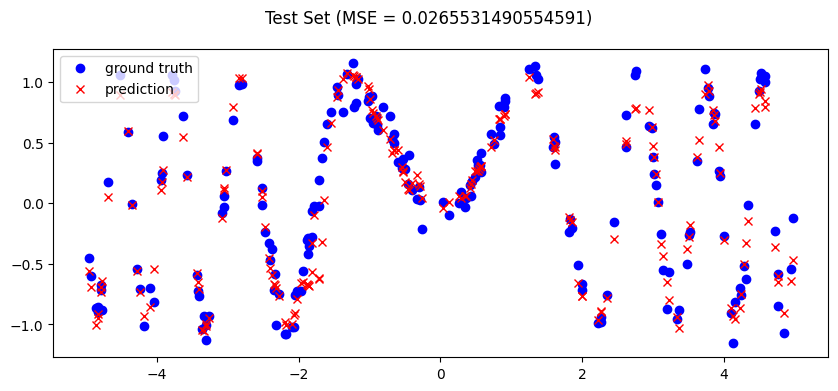

In [14]:
clf = LocallyWeightedLinearRegression(best_tau)
clf.fit(xtrain,ytrain)
ytest_pred = clf.predict(xtest)
loss_best_tau = np.mean((ytest_pred - ytest)**2)
plot_predictions(xtest,ytest,ytest_pred,f'Test Set (MSE = {np.mean((ytest_pred - ytest)**2)})')